11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
ReLU Training:
Epoch 1/100, Time: 23.22s, Loss: 0.1695, Val_Loss: 0.0524, Val_Acc: 0.9848
Epoch 2/100, Time: 7.69s, Loss: 0.0672, Val_Loss: 0.0724, Val_Acc: 0.9794
Epoch 3/100, Time: 4.74s, Loss: 0.0507, Val_Loss: 0.0304, Val_Acc: 0.9896
Epoch 4/100, Time: 5.29s, Loss: 0.0419, Val_Loss: 0.0277, Val_Acc: 0.9914
Epoch 5/100, Time: 5.17s, Loss: 0.0352, Val_Loss: 0.0278, Val_Acc: 0.9920
Epoch 6/100, Time: 4.55s, Loss: 0.0331, Val_Loss: 0.0287, Val_Acc: 0.9912
Epoch 7/100, Time: 4.86s, Loss: 0.0288, Val_Loss: 0.0252, Val_Acc: 0.9920
Epoch 8/100, Time: 4.68s, Loss: 0.0246, Val_Loss: 0.0261, Val_Acc: 0.9930
Epoch 9/100, Time: 5.19s, Loss: 0.0245, Val_Loss: 0.0202, Val_Acc: 0.9934
Epoch 10/100, Time: 4.92s, Loss: 0.0219, Val_Loss: 0.0228, Val_Acc: 0.9932
Epoch 11/100, Time: 5.07s, Loss: 0.0184, Val_Loss: 0.0210, Val_Acc: 0.9936
Epoch 12/100, Time: 4.90s, Loss: 0.0181, Val_Loss: 0.0236, Val_Acc: 0.9934
Epoch 13/100, Time: 4.76s, Loss: 0.0120, V

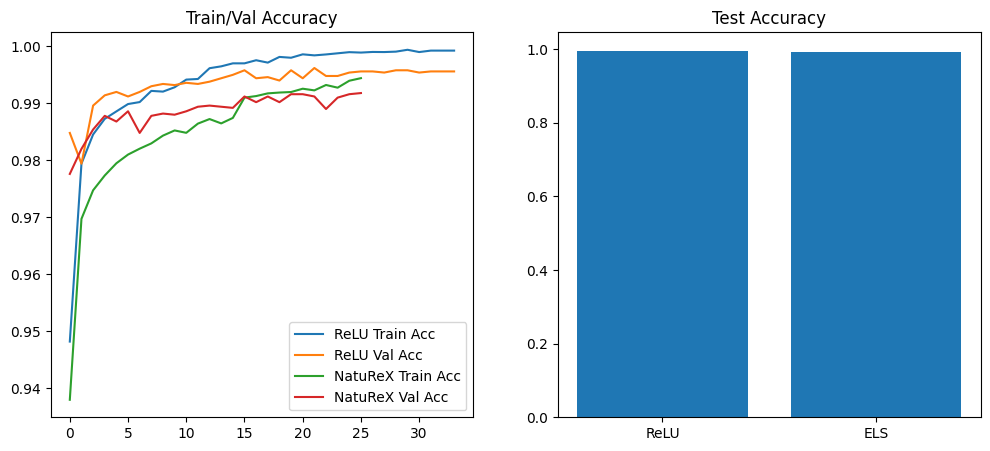

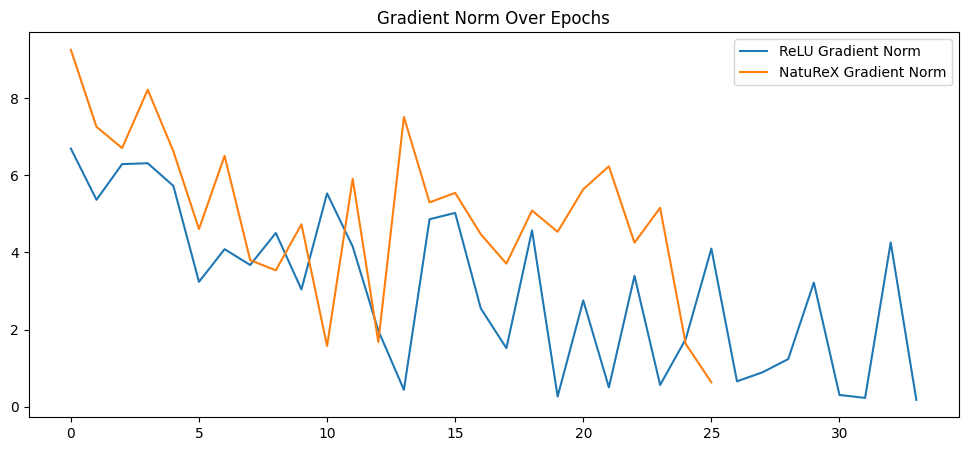

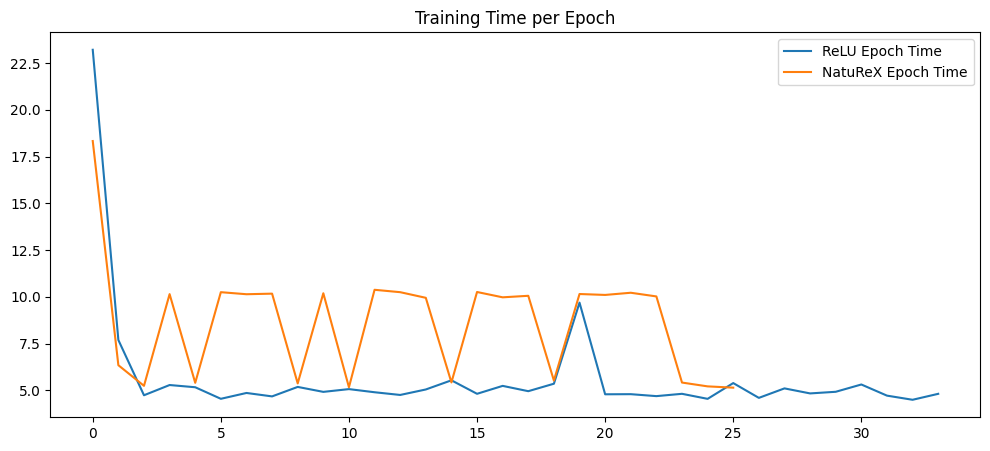

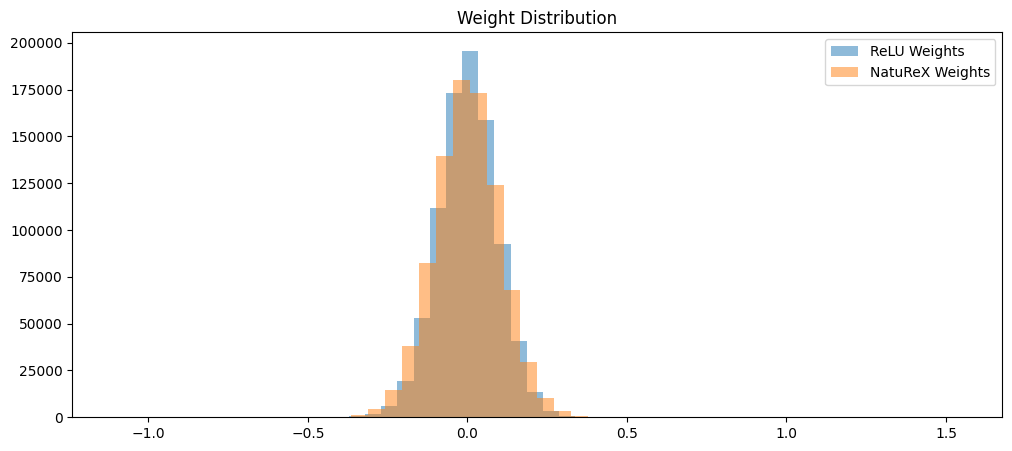

ReLU Model:
Test Accuracy: 0.9960
Sparsity: 0.0002
Total Training Time: 193.53s
NatuReX Model:
Test Accuracy: 0.9921
Sparsity: 0.0001
Total Training Time: 224.89s


In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import time

# Set seeds
tf.random.set_seed(42)
np.random.seed(42)

# Hyperparameters
batch_size = 64
learning_rate = 0.001
epochs = 100
num_classes = 10
val_size = 5000

# Load MNIST data
(x_train_full, y_train_full), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train_full = x_train_full.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0
# Expand dims for CNN (MNIST is grayscale, so 1 channel)
x_train_full = np.expand_dims(x_train_full, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

y_train_full = tf.keras.utils.to_categorical(y_train_full, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

# Split train/val
x_val = x_train_full[:val_size]
y_val = y_train_full[:val_size]
x_train = x_train_full[val_size:]
y_train = y_train_full[val_size:]

# Define NatuReX ELS activation
def els(x, A=10.0, n=2.0):
    return x / tf.sqrt(1.0 + (x / A)**(2.0 * n))


# Initializer
initializer = tf.keras.initializers.HeNormal()

# Build model function
def build_model(activation_func):
    inputs = tf.keras.Input(shape=(28,28,1))
    x = tf.keras.layers.Conv2D(32, (3,3), padding='same', kernel_initializer=initializer)(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(activation_func)(x)
    x = tf.keras.layers.Conv2D(32, (3,3), padding='same', kernel_initializer=initializer)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(activation_func)(x)
    x = tf.keras.layers.MaxPooling2D((2,2))(x)
    x = tf.keras.layers.Dropout(0.25)(x)

    x = tf.keras.layers.Conv2D(64, (3,3), padding='same', kernel_initializer=initializer)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(activation_func)(x)
    x = tf.keras.layers.Conv2D(64, (3,3), padding='same', kernel_initializer=initializer)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(activation_func)(x)
    x = tf.keras.layers.MaxPooling2D((2,2))(x)
    x = tf.keras.layers.Dropout(0.25)(x)

    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(256, kernel_initializer=initializer)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(activation_func)(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    model = tf.keras.Model(inputs, outputs)
    return model

# Custom callback for timing and gradients
class CustomCallback(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.train_times = []
        self.start_time = time.time()
        self.gradient_norms = []

    def on_epoch_end(self, epoch, logs=None):
        end_time = time.time()
        epoch_time = end_time - self.start_time
        self.train_times.append(epoch_time)
        self.start_time = end_time
        x_sample, y_sample = x_train[:batch_size], y_train[:batch_size]
        with tf.GradientTape() as tape:
            preds = self.model(x_sample, training=True)
            loss_value = tf.keras.losses.categorical_crossentropy(y_sample, preds)
        grads = tape.gradient(loss_value, self.model.trainable_variables)
        norm = np.mean([tf.norm(g).numpy() for g in grads if g is not None])
        self.gradient_norms.append(norm)
        print(f"Epoch {epoch+1}/{epochs}, Time: {epoch_time:.2f}s, "
              f"Loss: {logs.get('loss',0):.4f}, Val_Loss: {logs.get('val_loss',0):.4f}, "
              f"Val_Acc: {logs.get('val_accuracy',0):.4f}")

# Compute sparsity
def compute_sparsity(model):
    weights = []
    for w in model.trainable_variables:
        weights.extend(w.numpy().flatten())
    weights = np.array(weights)
    return np.mean(np.abs(weights) < 1e-5)

# Training for ReLU
print("ReLU Training:")
model_relu = build_model('relu')
model_relu.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

callback_relu = CustomCallback()
callbacks_relu = [
    callback_relu,
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3),
    tf.keras.callbacks.ModelCheckpoint("model_relu_best.keras", save_best_only=True, monitor='val_loss')
]

history_relu = model_relu.fit(x_train, y_train,
                              validation_data=(x_val, y_val),
                              epochs=epochs,
                              batch_size=batch_size,
                              verbose=0,
                              callbacks=callbacks_relu)

test_loss_relu, test_acc_relu = model_relu.evaluate(x_test, y_test, verbose=0)
relu_sparsity = compute_sparsity(model_relu)

# Training for ELS
print("NatuReX Training:")
model_els = build_model(els)
model_els.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

callback_els = CustomCallback()
callbacks_els = [
    callback_els,
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3),
    tf.keras.callbacks.ModelCheckpoint("model_els_best.keras", save_best_only=True, monitor='val_loss')
]

history_els = model_els.fit(x_train, y_train,
                            validation_data=(x_val, y_val),
                            epochs=epochs,
                            batch_size=batch_size,
                            verbose=0,
                            callbacks=callbacks_els)

test_loss_els, test_acc_els = model_els.evaluate(x_test, y_test, verbose=0)
els_sparsity = compute_sparsity(model_els)

model_relu.save("model_relu_final.keras")
model_els.save("model_els_final.keras")

# Plot accuracy
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history_relu.history['accuracy'], label='ReLU Train Acc')
plt.plot(history_relu.history['val_accuracy'], label='ReLU Val Acc')
plt.plot(history_els.history['accuracy'], label='NatuReX Train Acc')
plt.plot(history_els.history['val_accuracy'], label='NatuReX Val Acc')
plt.title('Train/Val Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.bar(['ReLU', 'ELS'], [test_acc_relu, test_acc_els])
plt.title('Test Accuracy')
plt.show()

# Plot gradient norms
plt.figure(figsize=(12,5))
plt.plot(callback_relu.gradient_norms, label='ReLU Gradient Norm')
plt.plot(callback_els.gradient_norms, label='NatuReX Gradient Norm')
plt.title('Gradient Norm Over Epochs')
plt.legend()
plt.show()

# Plot training times
plt.figure(figsize=(12,5))
plt.plot(callback_relu.train_times, label='ReLU Epoch Time')
plt.plot(callback_els.train_times, label='NatuReX Epoch Time')
plt.title('Training Time per Epoch')
plt.legend()
plt.show()

# Weight distributions
relu_weights = np.concatenate([w.numpy().flatten() for w in model_relu.trainable_variables])
els_weights = np.concatenate([w.numpy().flatten() for w in model_els.trainable_variables])

plt.figure(figsize=(12,5))
plt.hist(relu_weights, bins=50, alpha=0.5, label='ReLU Weights')
plt.hist(els_weights, bins=50, alpha=0.5, label='NatuReX Weights')
plt.title('Weight Distribution')
plt.legend()
plt.show()

print("ReLU Model:")
print(f"Test Accuracy: {test_acc_relu:.4f}")
print(f"Sparsity: {relu_sparsity:.4f}")
print(f"Total Training Time: {sum(callback_relu.train_times):.2f}s")

print("NatuReX Model:")
print(f"Test Accuracy: {test_acc_els:.4f}")
print(f"Sparsity: {els_sparsity:.4f}")
print(f"Total Training Time: {sum(callback_els.train_times):.2f}s")



Training Deeper/Wider ReLU Model...
Epoch 1/10
860/860 ━━━━━━━━━━━━━━━━━━━━ 24s 16ms/step - accuracy: 0.8372 - loss: 0.5047 - val_accuracy: 0.9848 - val_loss: 0.0541
Epoch 2/10
860/860 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9788 - loss: 0.0689 - val_accuracy: 0.9908 - val_loss: 0.0341
Epoch 3/10
860/860 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9836 - loss: 0.0496 - val_accuracy: 0.9918 - val_loss: 0.0293
Epoch 4/10
860/860 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.9861 - loss: 0.0459 - val_accuracy: 0.9852 - val_loss: 0.0437
Epoch 5/10
860/860 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.9882 - loss: 0.0372 - val_accuracy: 0.9908 - val_loss: 0.0298
Epoch 6/10
860/860 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.9896 - loss: 0.0329 - val_accuracy: 0.9920 - val_loss: 0.0294
Epoch 7/10
860/860 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.9898 - loss: 0.0305 - val_accuracy: 0.9920 - val_loss: 0.0268
Epoch 8/10
860/860 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy

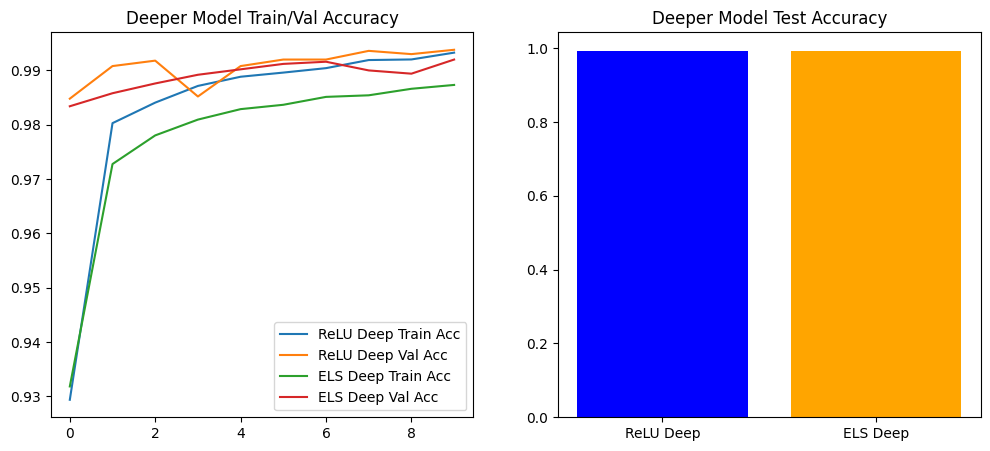

Done. The code included:
- Baseline training with ReLU and ELS (original model)
- Tracking training time, gradient norms, accuracy, sparsity
- Visualization of accuracy, gradient norms, weight distributions
- Loss landscape 1D slice (for ReLU model)
- Gradient flow analysis
- Deeper/Wider model training comparison for ReLU vs ELS


In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.initializers import HeNormal
import copy
# -------------------------------------------------------------
# Deeper or Wider Networks:
# Build a deeper/wider model and compare ReLU vs ELS
# -------------------------------------------------------------
def build_deeper_model(activation_func, depth_factor=3):
    # depth_factor controls how many times we repeat a block pattern
    # Each block: (Conv->BN->Act)*2 -> MaxPool -> Dropout
    # Filters double each block
    inputs = Input(shape=(28,28,1))
    x = inputs
    filters = 32
    for d in range(depth_factor):
        x = Conv2D(filters, (3,3), padding='same', kernel_initializer=initializer)(x)
        x = BatchNormalization()(x)
        x = Activation(activation_func)(x)
        x = Conv2D(filters, (3,3), padding='same', kernel_initializer=initializer)(x)
        x = BatchNormalization()(x)
        x = Activation(activation_func)(x)
        x = MaxPooling2D((2,2))(x)
        x = Dropout(0.25)(x)
        filters *= 2

    x = Flatten()(x)
    x = Dense(512, kernel_initializer=initializer)(x)
    x = BatchNormalization()(x)
    x = Activation(activation_func)(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs, outputs)
    return model

def train_and_evaluate_deeper(activation_func, name, depth_factor=3, epochs_deeper=10):
    model = build_deeper_model(activation_func, depth_factor=depth_factor)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
                  loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(x_train, y_train,
                        validation_data=(x_val, y_val),
                        epochs=epochs_deeper,
                        batch_size=batch_size,
                        verbose=1)
    test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
    print(f"{name} Deeper Model Test Accuracy: {test_acc:.4f}")
    return model, history, test_acc

print("\nTraining Deeper/Wider ReLU Model...")
model_relu_deep, history_relu_deep, acc_relu_deep = train_and_evaluate_deeper('relu', "ReLU", depth_factor=3, epochs_deeper=10)

print("\nTraining Deeper/Wider ELS Model...")
model_els_deep, history_els_deep, acc_els_deep = train_and_evaluate_deeper(els, "ELS", depth_factor=3, epochs_deeper=10)

# Compare their accuracies on deeper model
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history_relu_deep.history['accuracy'], label='ReLU Deep Train Acc')
plt.plot(history_relu_deep.history['val_accuracy'], label='ReLU Deep Val Acc')
plt.plot(history_els_deep.history['accuracy'], label='ELS Deep Train Acc')
plt.plot(history_els_deep.history['val_accuracy'], label='ELS Deep Val Acc')
plt.title('Deeper Model Train/Val Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.bar(['ReLU Deep', 'ELS Deep'], [acc_relu_deep, acc_els_deep], color=['blue', 'orange'])
plt.title('Deeper Model Test Accuracy')
plt.show()

print("Done. The code included:")
print("- Baseline training with ReLU and ELS (original model)")
print("- Tracking training time, gradient norms, accuracy, sparsity")
print("- Visualization of accuracy, gradient norms, weight distributions")
print("- Loss landscape 1D slice (for ReLU model)")
print("- Gradient flow analysis")
print("- Deeper/Wider model training comparison for ReLU vs ELS")


Visualizing feature maps for ReLU model
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


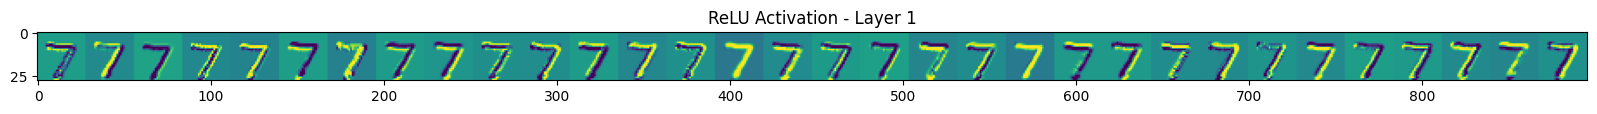

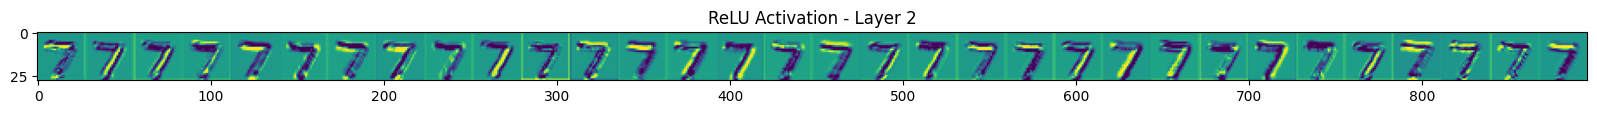

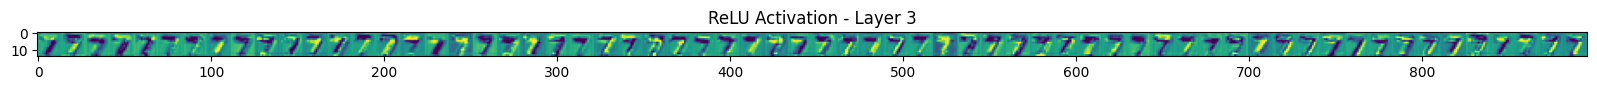

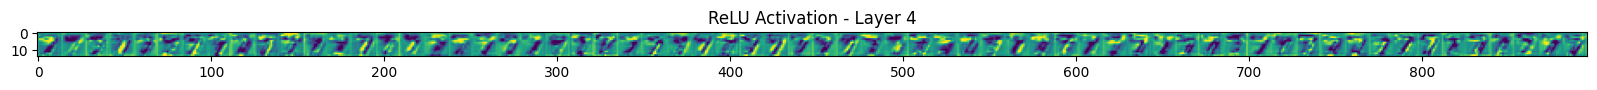


Visualizing feature maps for ELS model
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step


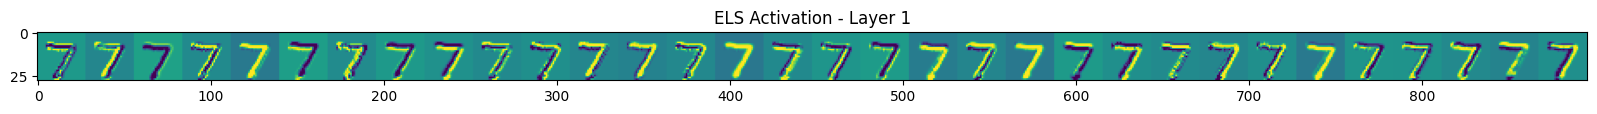

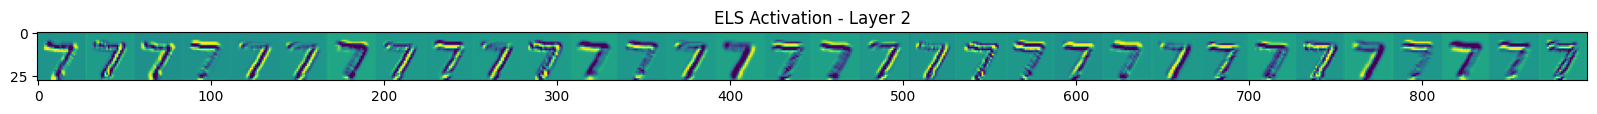

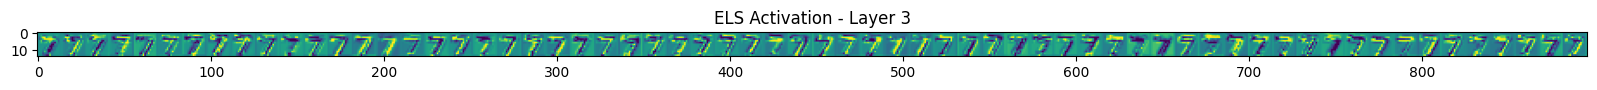

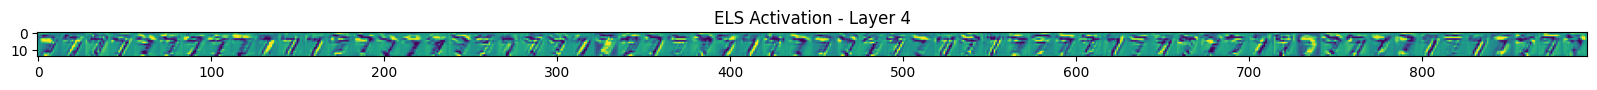

In [4]:
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.models import Model

def visualize_feature_maps(model, activation_function_name, x_test):
    test_image = x_test[0]
    test_image_expanded = np.expand_dims(test_image, axis=0)
    # Extract the outputs of all convolutional layers
    layer_outputs = [layer.output for layer in model.layers if isinstance(layer, Conv2D)]
    # Use model.input instead of model.layers[0].input
    input_img = model.input
    # Create a model that returns the outputs of these layers
    activation_model = Model(inputs=input_img, outputs=layer_outputs)
    activations = activation_model.predict(test_image_expanded)
    # Visualize each feature map
    for idx, activation in enumerate(activations):
        num_filters = activation.shape[-1]
        size = activation.shape[1]
        display_grid = np.zeros((size, size * num_filters))
        for i in range(num_filters):
            x = activation[0, :, :, i]
            x -= x.mean()
            x /= (x.std() + 1e-5)
            x *= 64
            x += 128
            x = np.clip(x, 0, 255).astype('uint8')
            display_grid[:, i * size : (i + 1) * size] = x
        scale = 20. / num_filters
        plt.figure(figsize=(scale * num_filters, scale))
        plt.title(f'{activation_function_name} Activation - Layer {idx+1}')
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')
        plt.show()

# Now call the function:
print("\nVisualizing feature maps for ReLU model")
visualize_feature_maps(model_relu, "ReLU", x_test)

print("\nVisualizing feature maps for ELS model")
visualize_feature_maps(model_els, "ELS", x_test)



Evaluating ReLU model on FGSM adversaries...
functional accuracy on FGSM (eps=0.1) adversarial examples: 0.6590

Evaluating ELS model on FGSM adversaries...
functional_1 accuracy on FGSM (eps=0.1) adversarial examples: 0.4890

Evaluating ReLU model on PGD adversaries...
functional accuracy on PGD (eps=0.1, alpha=0.01, steps=40) adversarial examples: 0.1140

Evaluating ELS model on PGD adversaries...
functional_1 accuracy on PGD (eps=0.1, alpha=0.01, steps=40) adversarial examples: 0.0090


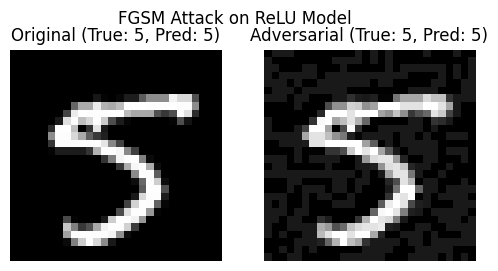

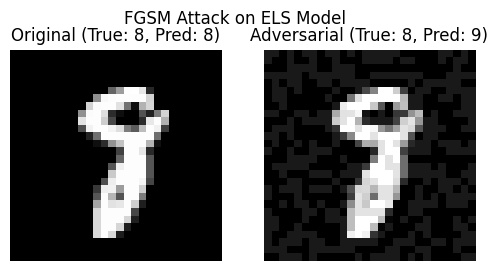

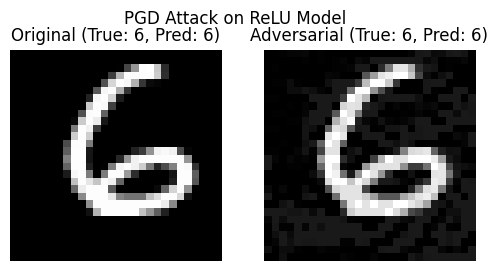

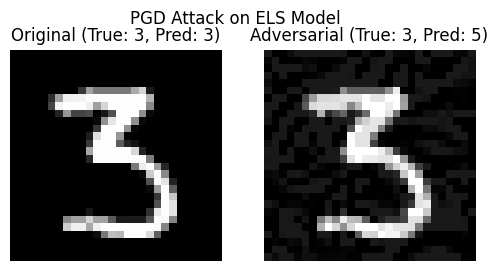

In [5]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Assume model_relu and model_els are already trained and available
# Assume x_test, y_test are also available (as in the previous code)
# Here we implement FGSM and PGD attacks on a subset of the test data.

# Parameters for attacks
epsilon = 0.1   # For FGSM: Maximum perturbation
pgd_steps = 40   # Number of steps for PGD
pgd_alpha = 0.01 # Step size for PGD
num_samples = 1000  # Number of test samples to evaluate

x_test_subset = x_test[:num_samples]
y_test_subset = y_test[:num_samples]

# Function to perform FGSM attack
def fgsm_attack(model, x, y_true, eps):
    x_adv = tf.identity(x)
    with tf.GradientTape() as tape:
        tape.watch(x_adv)
        preds = model(x_adv, training=False)
        loss = tf.keras.losses.categorical_crossentropy(y_true, preds)
    grads = tape.gradient(loss, x_adv)
    # Sign of the gradient
    signed_grads = tf.sign(grads)
    # Add perturbation
    x_adv = x_adv + eps * signed_grads
    # Clip to maintain valid pixel range [0,1]
    x_adv = tf.clip_by_value(x_adv, 0.0, 1.0)
    return x_adv

# Function to perform PGD attack
def pgd_attack(model, x, y_true, eps, alpha, steps):
    x_adv = tf.identity(x)
    x_orig = tf.identity(x)
    for i in range(steps):
        with tf.GradientTape() as tape:
            tape.watch(x_adv)
            preds = model(x_adv, training=False)
            loss = tf.keras.losses.categorical_crossentropy(y_true, preds)
        grads = tape.gradient(loss, x_adv)
        signed_grads = tf.sign(grads)
        x_adv = x_adv + alpha * signed_grads
        # Project the perturbation onto the L-infinity ball of radius eps
        x_adv = tf.clip_by_value(x_adv, x_orig - eps, x_orig + eps)
        # Clip to maintain valid pixel range [0,1]
        x_adv = tf.clip_by_value(x_adv, 0.0, 1.0)
    return x_adv

# Evaluate model on adversarial examples
def evaluate_on_adversarial(model, x_data, y_data, attack_fn, attack_name):
    # Generate adversarial examples
    x_adv = attack_fn(model, x_data, y_data)
    # Evaluate accuracy on adversarial examples
    preds = model.predict(x_adv, verbose=0)
    acc = np.mean(np.argmax(preds, axis=1) == np.argmax(y_data, axis=1))
    print(f"{model.name} accuracy on {attack_name} adversarial examples: {acc:.4f}")
    return x_adv

# Evaluate both models on FGSM adversaries
print("\nEvaluating ReLU model on FGSM adversaries...")
x_adv_relu_fgsm = evaluate_on_adversarial(model_relu, x_test_subset, y_test_subset,
                                          lambda m, x, y: fgsm_attack(m, x, y, epsilon),
                                          f"FGSM (eps={epsilon})")

print("\nEvaluating ELS model on FGSM adversaries...")
x_adv_els_fgsm = evaluate_on_adversarial(model_els, x_test_subset, y_test_subset,
                                         lambda m, x, y: fgsm_attack(m, x, y, epsilon),
                                         f"FGSM (eps={epsilon})")

# Evaluate both models on PGD adversaries
print("\nEvaluating ReLU model on PGD adversaries...")
x_adv_relu_pgd = evaluate_on_adversarial(model_relu, x_test_subset, y_test_subset,
                                         lambda m, x, y: pgd_attack(m, x, y, epsilon, pgd_alpha, pgd_steps),
                                         f"PGD (eps={epsilon}, alpha={pgd_alpha}, steps={pgd_steps})")

print("\nEvaluating ELS model on PGD adversaries...")
x_adv_els_pgd = evaluate_on_adversarial(model_els, x_test_subset, y_test_subset,
                                        lambda m, x, y: pgd_attack(m, x, y, epsilon, pgd_alpha, pgd_steps),
                                        f"PGD (eps={epsilon}, alpha={pgd_alpha}, steps={pgd_steps})")

# Visualize some adversarial examples
def visualize_adversarial_examples(x_orig, x_adv, y_true, model, title):
    idx = np.random.randint(0, len(x_orig))
    orig_image = x_orig[idx]
    adv_image = x_adv[idx]
    true_label = np.argmax(y_true[idx])
    pred_orig = np.argmax(model.predict(np.expand_dims(orig_image,0), verbose=0))
    pred_adv = np.argmax(model.predict(np.expand_dims(adv_image,0), verbose=0))

    # Ensure numpy arrays
    if isinstance(orig_image, tf.Tensor):
        orig_image = orig_image.numpy()
    if isinstance(adv_image, tf.Tensor):
        adv_image = adv_image.numpy()

    plt.figure(figsize=(6,3))
    plt.subplot(1,2,1)
    plt.title(f"Original (True: {true_label}, Pred: {pred_orig})")
    # If shape is (28,28,1), display the first channel
    plt.imshow(orig_image[...,0], cmap='gray')
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.title(f"Adversarial (True: {true_label}, Pred: {pred_adv})")
    plt.imshow(adv_image[...,0], cmap='gray')
    plt.axis('off')
    plt.suptitle(title)
    plt.show()


# Visualize for FGSM (ReLU)
visualize_adversarial_examples(x_test_subset, x_adv_relu_fgsm, y_test_subset, model_relu, "FGSM Attack on ReLU Model")

# Visualize for FGSM (ELS)
visualize_adversarial_examples(x_test_subset, x_adv_els_fgsm, y_test_subset, model_els, "FGSM Attack on ELS Model")

# Visualize for PGD (ReLU)
visualize_adversarial_examples(x_test_subset, x_adv_relu_pgd, y_test_subset, model_relu, "PGD Attack on ReLU Model")

# Visualize for PGD (ELS)
visualize_adversarial_examples(x_test_subset, x_adv_els_pgd, y_test_subset, model_els, "PGD Attack on ELS Model")


In [7]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time

# Set seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Hyperparameters
batch_size = 64
learning_rate = 0.001
epochs = 100   # Reduced for demonstration; can increase if desired
num_classes = 10
val_size = 5000

# Load MNIST data
(x_train_full, y_train_full), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train_full = x_train_full.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# Expand dims for CNN (MNIST is grayscale, so 1 channel)
x_train_full = np.expand_dims(x_train_full, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

y_train_full = tf.keras.utils.to_categorical(y_train_full, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

# Split train/val
x_val = x_train_full[:val_size]
y_val = y_train_full[:val_size]
x_train = x_train_full[val_size:]
y_train = y_train_full[val_size:]

# Define NatuReX activation
# f(x) = x / sqrt(1 + (x/A)^(2n))
def naturex(x, A=10.0, n=2.0):
    return x / tf.sqrt(1.0 + (x / A)**(2.0 * n))


# Initializer
initializer = tf.keras.initializers.HeNormal()

def build_model(activation_func, A=None, n=None, model_name="model"):
    inputs = tf.keras.Input(shape=(28,28,1))
    # If using NatuReX activation, create a lambda layer to apply it
    def act_layer(x):
        if activation_func == 'relu':
            return tf.nn.relu(x)
        else:
            return naturex(x, A=A, n=n)

    x = tf.keras.layers.Conv2D(32, (3,3), padding='same', kernel_initializer=initializer)(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Lambda(act_layer)(x)

    x = tf.keras.layers.Conv2D(32, (3,3), padding='same', kernel_initializer=initializer)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Lambda(act_layer)(x)
    x = tf.keras.layers.MaxPooling2D((2,2))(x)
    x = tf.keras.layers.Dropout(0.25)(x)

    x = tf.keras.layers.Conv2D(64, (3,3), padding='same', kernel_initializer=initializer)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Lambda(act_layer)(x)

    x = tf.keras.layers.Conv2D(64, (3,3), padding='same', kernel_initializer=initializer)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Lambda(act_layer)(x)
    x = tf.keras.layers.MaxPooling2D((2,2))(x)
    x = tf.keras.layers.Dropout(0.25)(x)

    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(256, kernel_initializer=initializer)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Lambda(act_layer)(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    model = tf.keras.Model(inputs, outputs, name=model_name)
    return model

# Custom callback for timing and gradients
class CustomCallback(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.train_times = []
        self.start_time = time.time()
        self.gradient_norms = []

    def on_epoch_end(self, epoch, logs=None):
        end_time = time.time()
        epoch_time = end_time - self.start_time
        self.train_times.append(epoch_time)
        self.start_time = end_time
        x_sample, y_sample = x_train[:batch_size], y_train[:batch_size]
        with tf.GradientTape() as tape:
            preds = self.model(x_sample, training=True)
            loss_value = tf.keras.losses.categorical_crossentropy(y_sample, preds)
        grads = tape.gradient(loss_value, self.model.trainable_variables)
        norm = np.mean([tf.norm(g).numpy() for g in grads if g is not None])
        self.gradient_norms.append(norm)
        print(f"Epoch {epoch+1}/{epochs}, Time: {epoch_time:.2f}s, "
              f"Loss: {logs.get('loss',0):.4f}, Val_Loss: {logs.get('val_loss',0):.4f}, "
              f"Val_Accuracy: {logs.get('val_accuracy',0):.4f}")


def compute_sparsity(model):
    weights = []
    for w in model.trainable_variables:
        weights.extend(w.numpy().flatten())
    weights = np.array(weights)
    return np.mean(np.abs(weights) < 1e-5)


# --- Train ReLU model once ---
print("Training ReLU baseline model...")
model_relu = build_model('relu', model_name="relu_model")
model_relu.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

callback_relu = CustomCallback()
callbacks_relu = [
    callback_relu,
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)
]

history_relu = model_relu.fit(x_train, y_train,
                              validation_data=(x_val, y_val),
                              epochs=epochs,
                              batch_size=batch_size,
                              verbose=0,
                              callbacks=callbacks_relu)

test_loss_relu, test_acc_relu = model_relu.evaluate(x_test, y_test, verbose=0)
relu_sparsity = compute_sparsity(model_relu)

print(f"ReLU Model:\nTest Accuracy: {test_acc_relu:.4f}\nSparsity: {relu_sparsity:.4f}\n"
      f"Total Training Time: {sum(callback_relu.train_times):.2f}s")


# --- Train NatuReX models with different A, n, and optimizer ---
A_values = [2.0, 10.0, 20.0, 50.0]   # you can add more values
n_values = [2.0, 3.0, 4.0, 5.0]    # you can add more values
optimizers = [tf.keras.optimizers.Adam(learning_rate), tf.keras.optimizers.SGD(learning_rate=learning_rate)]

naturex_models = {}

for opt in optimizers:
    opt_name = type(opt).__name__
    for A_val in A_values:
        for n_val in n_values:
            model_name = f"naturex_A{A_val}_n{n_val}_{opt_name}"
            print(f"\nTraining NatuReX model with A={A_val}, n={n_val}, optimizer={opt_name}...")
            model_naturex = build_model('naturex', A=A_val, n=n_val, model_name=model_name)
            model_naturex.compile(optimizer=opt,
                                  loss='categorical_crossentropy',
                                  metrics=['accuracy'])
            callback_nx = CustomCallback()
            callbacks_nx = [
                callback_nx,
                tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
                tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)
            ]
            model_naturex.fit(x_train, y_train,
                              validation_data=(x_val, y_val),
                              epochs=epochs,
                              batch_size=batch_size,
                              verbose=0,
                              callbacks=callbacks_nx)

            test_loss_nx, test_acc_nx = model_naturex.evaluate(x_test, y_test, verbose=0)
            nx_sparsity = compute_sparsity(model_naturex)

            print(f"NatuReX (A={A_val}, n={n_val}, {opt_name}):\nTest Accuracy: {test_acc_nx:.4f}\n"
                  f"Sparsity: {nx_sparsity:.4f}\nTotal Training Time: {sum(callback_nx.train_times):.2f}s")

            naturex_models[model_name] = {
                'model': model_naturex,
                'test_acc': test_acc_nx,
                'sparsity': nx_sparsity
            }

# Attack code (FGSM and PGD)
epsilon = 0.1
pgd_steps = 40
pgd_alpha = 0.01
num_samples = 1000
x_test_subset = x_test[:num_samples]
y_test_subset = y_test[:num_samples]

def fgsm_attack(model, x, y_true, eps):
    x_adv = tf.identity(x)
    with tf.GradientTape() as tape:
        tape.watch(x_adv)
        preds = model(x_adv, training=False)
        loss = tf.keras.losses.categorical_crossentropy(y_true, preds)
    grads = tape.gradient(loss, x_adv)
    signed_grads = tf.sign(grads)
    x_adv = x_adv + eps * signed_grads
    x_adv = tf.clip_by_value(x_adv, 0.0, 1.0)
    return x_adv

def pgd_attack(model, x, y_true, eps, alpha, steps):
    x_adv = tf.identity(x)
    x_orig = tf.identity(x)
    for i in range(steps):
        with tf.GradientTape() as tape:
            tape.watch(x_adv)
            preds = model(x_adv, training=False)
            loss = tf.keras.losses.categorical_crossentropy(y_true, preds)
        grads = tape.gradient(loss, x_adv)
        signed_grads = tf.sign(grads)
        x_adv = x_adv + alpha * signed_grads
        x_adv = tf.clip_by_value(x_adv, x_orig - eps, x_orig + eps)
        x_adv = tf.clip_by_value(x_adv, 0.0, 1.0)
    return x_adv

def evaluate_on_adversarial(model, x_data, y_data, attack_fn, attack_name):
    x_adv = attack_fn(model, x_data, y_data)
    preds = model.predict(x_adv, verbose=0)
    acc = np.mean(np.argmax(preds, axis=1) == np.argmax(y_data, axis=1))
    print(f"{model.name} accuracy on {attack_name} adversarial examples: {acc:.4f}")
    return acc

# Evaluate ReLU model on adversarial examples
print("\nEvaluating ReLU model on adversarial attacks...")
evaluate_on_adversarial(model_relu, x_test_subset, y_test_subset,
                        lambda m, x, y: fgsm_attack(m, x, y, epsilon),
                        f"FGSM (eps={epsilon})")

evaluate_on_adversarial(model_relu, x_test_subset, y_test_subset,
                        lambda m, x, y: pgd_attack(m, x, y, epsilon, pgd_alpha, pgd_steps),
                        f"PGD (eps={epsilon}, alpha={pgd_alpha}, steps={pgd_steps})")


# Evaluate each NatuReX model on adversarial examples
for model_name, info in naturex_models.items():
    model_nx = info['model']
    print(f"\nEvaluating {model_name} on adversarial attacks...")
    fgsm_acc = evaluate_on_adversarial(model_nx, x_test_subset, y_test_subset,
                                       lambda m, x, y: fgsm_attack(m, x, y, epsilon),
                                       f"FGSM (eps={epsilon})")

    pgd_acc = evaluate_on_adversarial(model_nx, x_test_subset, y_test_subset,
                                      lambda m, x, y: pgd_attack(m, x, y, epsilon, pgd_alpha, pgd_steps),
                                      f"PGD (eps={epsilon}, alpha={pgd_alpha}, steps={pgd_steps})")


Training ReLU baseline model...
Epoch 1/100, Time: 19.83s, Loss: 0.1584, Val_Loss: 0.0495, Val_Accuracy: 0.9856
Epoch 2/100, Time: 11.71s, Loss: 0.0625, Val_Loss: 0.0467, Val_Accuracy: 0.9858
Epoch 3/100, Time: 4.51s, Loss: 0.0468, Val_Loss: 0.0308, Val_Accuracy: 0.9908
Epoch 4/100, Time: 4.67s, Loss: 0.0413, Val_Loss: 0.0275, Val_Accuracy: 0.9922
Epoch 5/100, Time: 5.17s, Loss: 0.0337, Val_Loss: 0.0217, Val_Accuracy: 0.9936
Epoch 6/100, Time: 10.94s, Loss: 0.0316, Val_Loss: 0.0216, Val_Accuracy: 0.9936
Epoch 7/100, Time: 4.55s, Loss: 0.0262, Val_Loss: 0.0267, Val_Accuracy: 0.9920
Epoch 8/100, Time: 5.61s, Loss: 0.0235, Val_Loss: 0.0220, Val_Accuracy: 0.9938
Epoch 9/100, Time: 4.81s, Loss: 0.0166, Val_Loss: 0.0171, Val_Accuracy: 0.9952
Epoch 10/100, Time: 5.05s, Loss: 0.0144, Val_Loss: 0.0185, Val_Accuracy: 0.9954
Epoch 11/100, Time: 5.13s, Loss: 0.0132, Val_Loss: 0.0183, Val_Accuracy: 0.9944
Epoch 12/100, Time: 4.83s, Loss: 0.0105, Val_Loss: 0.0165, Val_Accuracy: 0.9954
Epoch 13/100, 

ValueError: Unknown variable: <KerasVariable shape=(3, 3, 1, 32), dtype=float32, path=conv2d_32/kernel>. This optimizer can only be called for the variables it was originally built with. When working with a new set of variables, you should recreate a new optimizer instance.

In [8]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time

# Set seeds
tf.random.set_seed(42)
np.random.seed(42)

# Hyperparameters
batch_size = 64
learning_rate = 0.001
epochs = 10
num_classes = 10
val_size = 5000

# Load and preprocess MNIST
(x_train_full, y_train_full), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train_full = x_train_full.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0
x_train_full = np.expand_dims(x_train_full, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)
y_train_full = tf.keras.utils.to_categorical(y_train_full, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

x_val = x_train_full[:val_size]
y_val = y_train_full[:val_size]
x_train = x_train_full[val_size:]
y_train = y_train_full[val_size:]

# Define NatuReX activation
def naturex(x, A=10.0, n=2.0):
    return x / tf.sqrt(1.0 + (x / A)**(2.0 * n))

initializer = tf.keras.initializers.HeNormal()

def build_model(activation_func, A=None, n=None, model_name="model"):
    def act_layer(x):
        if activation_func == 'relu':
            return tf.nn.relu(x)
        else:
            return naturex(x, A=A, n=n)

    inputs = tf.keras.Input(shape=(28,28,1))
    x = tf.keras.layers.Conv2D(32, (3,3), padding='same', kernel_initializer=initializer)(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Lambda(act_layer)(x)

    x = tf.keras.layers.Conv2D(32, (3,3), padding='same', kernel_initializer=initializer)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Lambda(act_layer)(x)
    x = tf.keras.layers.MaxPooling2D((2,2))(x)
    x = tf.keras.layers.Dropout(0.25)(x)

    x = tf.keras.layers.Conv2D(64, (3,3), padding='same', kernel_initializer=initializer)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Lambda(act_layer)(x)

    x = tf.keras.layers.Conv2D(64, (3,3), padding='same', kernel_initializer=initializer)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Lambda(act_layer)(x)
    x = tf.keras.layers.MaxPooling2D((2,2))(x)
    x = tf.keras.layers.Dropout(0.25)(x)

    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(256, kernel_initializer=initializer)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Lambda(act_layer)(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    model = tf.keras.Model(inputs, outputs, name=model_name)
    return model

class CustomCallback(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.train_times = []
        self.start_time = time.time()
        self.gradient_norms = []

    def on_epoch_end(self, epoch, logs=None):
        end_time = time.time()
        epoch_time = end_time - self.start_time
        self.train_times.append(epoch_time)
        self.start_time = end_time
        x_sample, y_sample = x_train[:batch_size], y_train[:batch_size]
        with tf.GradientTape() as tape:
            preds = self.model(x_sample, training=True)
            loss_value = tf.keras.losses.categorical_crossentropy(y_sample, preds)
        grads = tape.gradient(loss_value, self.model.trainable_variables)
        norm = np.mean([tf.norm(g).numpy() for g in grads if g is not None])
        self.gradient_norms.append(norm)
        print(f"Epoch {epoch+1}/{epochs}, Time: {epoch_time:.2f}s, "
              f"Loss: {logs.get('loss',0):.4f}, Val_Loss: {logs.get('val_loss',0):.4f}, "
              f"Val_Accuracy: {logs.get('val_accuracy',0):.4f}")

def compute_sparsity(model):
    weights = []
    for w in model.trainable_variables:
        weights.extend(w.numpy().flatten())
    weights = np.array(weights)
    return np.mean(np.abs(weights) < 1e-5)

print("Training ReLU baseline model...")
model_relu = build_model('relu', model_name="relu_model")
model_relu.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

callback_relu = CustomCallback()
callbacks_relu = [
    callback_relu,
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)
]

model_relu.fit(x_train, y_train,
               validation_data=(x_val, y_val),
               epochs=100,
               batch_size=batch_size,
               verbose=1,
               callbacks=callbacks_relu)

test_loss_relu, test_acc_relu = model_relu.evaluate(x_test, y_test, verbose=0)
relu_sparsity = compute_sparsity(model_relu)
print(f"ReLU Model:\nTest Accuracy: {test_acc_relu:.4f}\nSparsity: {relu_sparsity:.4f}\n"
      f"Total Training Time: {sum(callback_relu.train_times):.2f}s")

# Different parameter sets for NatuReX
A_values = [2.0, 10.0]
n_values = [2.0, 3.0]

# We'll try multiple optimizers. For each model, create a new optimizer instance.
optimizer_classes = [tf.keras.optimizers.Adam, tf.keras.optimizers.SGD]

naturex_models = {}

for opt_class in optimizer_classes:
    opt_name = opt_class.__name__
    for A_val in A_values:
        for n_val in n_values:
            print(f"\nTraining NatuReX model with A={A_val}, n={n_val}, optimizer={opt_name}...")
            model_name = f"naturex_A{A_val}_n{n_val}_{opt_name}"
            model_naturex = build_model('naturex', A=A_val, n=n_val, model_name=model_name)
            # Create a fresh optimizer instance for each model
            optimizer_instance = opt_class(learning_rate=learning_rate)
            model_naturex.compile(optimizer=optimizer_instance,
                                  loss='categorical_crossentropy',
                                  metrics=['accuracy'])
            callback_nx = CustomCallback()
            callbacks_nx = [
                callback_nx,
                tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
                tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)
            ]
            model_naturex.fit(x_train, y_train,
                              validation_data=(x_val, y_val),
                              epochs=100,
                              batch_size=batch_size,
                              verbose=1,
                              callbacks=callbacks_nx)

            test_loss_nx, test_acc_nx = model_naturex.evaluate(x_test, y_test, verbose=0)
            nx_sparsity = compute_sparsity(model_naturex)

            print(f"NatuReX (A={A_val}, n={n_val}, {opt_name}):\n"
                  f"Test Accuracy: {test_acc_nx:.4f}\nSparsity: {nx_sparsity:.4f}\n"
                  f"Total Training Time: {sum(callback_nx.train_times):.2f}s")

            naturex_models[model_name] = {
                'model': model_naturex,
                'test_acc': test_acc_nx,
                'sparsity': nx_sparsity
            }

# Adversarial evaluation
epsilon = 0.1
pgd_steps = 40
pgd_alpha = 0.01
num_samples = 1000
x_test_subset = x_test[:num_samples]
y_test_subset = y_test[:num_samples]

def fgsm_attack(model, x, y_true, eps):
    x_adv = tf.identity(x)
    with tf.GradientTape() as tape:
        tape.watch(x_adv)
        preds = model(x_adv, training=False)
        loss = tf.keras.losses.categorical_crossentropy(y_true, preds)
    grads = tape.gradient(loss, x_adv)
    signed_grads = tf.sign(grads)
    x_adv = x_adv + eps * signed_grads
    x_adv = tf.clip_by_value(x_adv, 0.0, 1.0)
    return x_adv

def pgd_attack(model, x, y_true, eps, alpha, steps):
    x_adv = tf.identity(x)
    x_orig = tf.identity(x)
    for i in range(steps):
        with tf.GradientTape() as tape:
            tape.watch(x_adv)
            preds = model(x_adv, training=False)
            loss = tf.keras.losses.categorical_crossentropy(y_true, preds)
        grads = tape.gradient(loss, x_adv)
        signed_grads = tf.sign(grads)
        x_adv = x_adv + alpha * signed_grads
        x_adv = tf.clip_by_value(x_adv, x_orig - eps, x_orig + eps)
        x_adv = tf.clip_by_value(x_adv, 0.0, 1.0)
    return x_adv

def evaluate_on_adversarial(model, x_data, y_data, attack_fn, attack_name):
    x_adv = attack_fn(model, x_data, y_data)
    preds = model.predict(x_adv, verbose=0)
    acc = np.mean(np.argmax(preds, axis=1) == np.argmax(y_data, axis=1))
    print(f"{model.name} accuracy on {attack_name} adversarial examples: {acc:.4f}")
    return acc

print("\nEvaluating ReLU model on adversarial attacks...")
evaluate_on_adversarial(model_relu, x_test_subset, y_test_subset,
                        lambda m, x, y: fgsm_attack(m, x, y, epsilon),
                        f"FGSM (eps={epsilon})")
evaluate_on_adversarial(model_relu, x_test_subset, y_test_subset,
                        lambda m, x, y: pgd_attack(m, x, y, epsilon, pgd_alpha, pgd_steps),
                        f"PGD (eps={epsilon}, alpha={pgd_alpha}, steps={pgd_steps})")

for model_name, info in naturex_models.items():
    model_nx = info['model']
    print(f"\nEvaluating {model_name} on adversarial attacks...")
    evaluate_on_adversarial(model_nx, x_test_subset, y_test_subset,
                            lambda m, x, y: fgsm_attack(m, x, y, epsilon),
                            f"FGSM (eps={epsilon})")
    evaluate_on_adversarial(model_nx, x_test_subset, y_test_subset,
                            lambda m, x, y: pgd_attack(m, x, y, epsilon, pgd_alpha, pgd_steps),
                            f"PGD (eps={epsilon}, alpha={pgd_alpha}, steps={pgd_steps})")


Training ReLU baseline model...
Epoch 1/100
860/860 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8815 - loss: 0.3801Epoch 1/10, Time: 15.82s, Loss: 0.1819, Val_Loss: 0.0589, Val_Accuracy: 0.9826
860/860 ━━━━━━━━━━━━━━━━━━━━ 16s 11ms/step - accuracy: 0.8815 - loss: 0.3798 - val_accuracy: 0.9826 - val_loss: 0.0589 - learning_rate: 0.0010
Epoch 2/100
860/860 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9796 - loss: 0.0685Epoch 2/10, Time: 5.19s, Loss: 0.0637, Val_Loss: 0.0380, Val_Accuracy: 0.9882
860/860 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9796 - loss: 0.0685 - val_accuracy: 0.9882 - val_loss: 0.0380 - learning_rate: 0.0010
Epoch 3/100
853/860 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9855 - loss: 0.0487Epoch 3/10, Time: 5.27s, Loss: 0.0497, Val_Loss: 0.0310, Val_Accuracy: 0.9908
860/860 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9855 - loss: 0.0487 - val_accuracy: 0.9908 - val_loss: 0.0310 - learning_rate: 0.0010
Epoch 4/100
859/860 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/s